# Example

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
import matplotlib
% matplotlib inline
from subprocess import call, Popen, PIPE

from madminer import GoldMine, Smithy
from madminer.tools.plots import plot_2d_morphing_basis

## 1. Define parameter space

In [2]:
miner = GoldMine()

miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=3,
    parameter_name='fW',
    morphing_max_power=4,
    parameter_range=(-1.,1.)
)
miner.add_parameter(
    lha_block='ANOINPUTS',
    lha_id=7,
    parameter_name='fWW',
    morphing_max_power=4,
    parameter_range=(-1.,1.)
)

## 2. Define benchmark points (evaluation points for |M|^2)

### 2a. Set benchmarks by hand

In [ ]:
miner.add_benchmark(
    {'fW':0., 'fWW':0.},
    'sm'
)

### 2b. Optimize benchmarks for morphing

In [ ]:
miner.set_benchmarks_from_morphing(keep_existing_benchmarks=True,
                                   n_bases=1,
                                   n_trials=100,
                                   n_test_thetas=100)

### Plot morphing basis and squared morphing weights (optional)

In [ ]:
fig = plot_2d_morphing_basis(miner.morpher, xlabel=r'$f_{W}$', ylabel=r'$f_{WW}$')

## 3. Save settings and run MadGraph

In [ ]:
miner.save('data/madminer_example.h5')

In [ ]:
miner.run(
    mg_directory='/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2',
    proc_card_file='./templates/proc_card.dat',
    param_card_template_file='./templates/param_card_template.dat',
    reweight_card_template_file='./templates/reweight_card_template.dat',
    run_card_file='./templates/run_card.dat',
    sample_benchmark='sm',
    initial_command='source activate python2'
)

## 4. Run detector simulation and extract observables

To increase flexibility, this is not part of the madminer package. The delphesminer package includes the necessary steps based on Delphes

In [ ]:
from delphesminer import DelphesMiner
dm = DelphesMiner()

In [ ]:
dm.add_hepmc_sample('./MG_process/to/hepmc_events.hepmc')
dm.run_delphes('path/to/delphes_folder', 'path/to/delphes_card.dat', log_folder='.')

In [ ]:
dm.add_observable('j1_e', 'j[0].e')
dm.add_observable('n_jets', 'len(j)')
dm.add_observable('e1_eta', 'e[0].eta')
dm.add_observable('mu1_phi', 'mu[0].phi()')
dm.add_observable('met', 'met.pt')

dm.analyse_delphes_samples()

In [ ]:
dm.save('data/madminer_example_with_data.h5', 'data/madminer_example.h5')

## 5. Make training and test samples

In [3]:
smithy = Smithy('data/madminer_example_with_data.h5')

OrderedDict([('fW', ('ANOINPUTS', 3, 4, (-1.0, 1.0))), ('fWW', ('ANOINPUTS', 7, 4, (-1.0, 1.0)))])
True


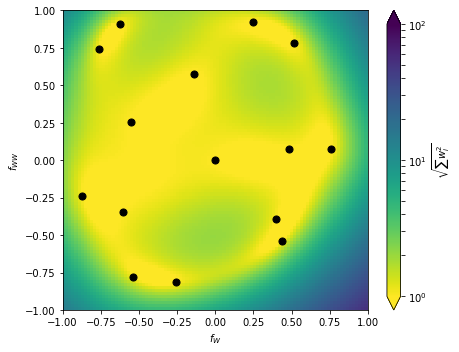

In [4]:
print(smithy.parameters)
print(miner.parameters == smithy.parameters)
fig = plot_2d_morphing_basis(smithy.morpher, xlabel=r'$f_{W}$', ylabel=r'$f_{WW}$')

In [5]:
theta, x, gold = smithy.extract_sample(theta_sampling_types=['benchmark'],
                                       theta_sampling_values=[0],
                                       n_samples_per_theta=10,
                                       augmented_data_definitions=[('ratio', 'benchmark', 1, 'benchmark', 0)])

ValueError: Inconsistent numbers of benchmarks: 4 in observations, 15 in benchmark list, 15 in morphing matrix